#             **Create_Renamed_Folders_with_Proper_LAS_filenames_by_Runs**

---
---
# This is a helper file to rename all LAS files with SOURCE and start/stop depths added to the names and try to add a prefix for run number.

### First attempt to add a prefix for each run starting from *file_directory* copying all files to the *file_directory_rename* folder:

    - Uses SOURCE in LAS File and start/stop depths. 
    - If no source, maybe this is a processed file product that will go to the *file_directory_rename/Processed_Data* folder.

**Hand check all files and prefix. Move files abd alter the run numbers if this makes more sense. This is just a start.** 

It appears that this next cell code will over-right the "_rename" data, but check it out to be sure. 

## If you have the new **"_rename"** subdirectories, then this next code cell is not necessary. 


In [1]:
import warnings
warnings.filterwarnings("ignore")


import matplotlib.pyplot as plt
import matplotlib.patches as mpatches  # Import for manually creating colored legend labels

import os, glob, re
import numpy as np
import pandas as pd
import lasio
import panel as pn

pn.extension("tabulator")
pn.config.sizing_mode = "stretch_width"

RUN_PAD = 2
TD_WINDOW_FT = 30.0
OUTPUT_SUFFIX = "_renamed"
PATTERN = "*.las"
HIDE_SUFFIXES = ("_rename", "_renamed")

def strip_existing_prefix(name: str) -> str:
    return re.sub(r"^\d+[_-]+", "", name)

def clean_for_filename(val: str) -> str:
    if not val:
        return "NOSOURCE"
    val = str(val).strip()
    if ":" in val:
        val = val.split(":", 1)[0].strip()
    val = re.sub(r"\.dlis$", "", val, flags=re.IGNORECASE)
    val = re.sub(r"\s+", "_", val)
    val = re.sub(r"[^A-Za-z0-9_\-\.]+", "_", val)
    return val or "SOURCE"

def clean_notes_for_filename(val: str) -> str:
    if val is None:
        return "NONOTES"
    s = str(val).strip()
    if s == "":
        return "NONOTES"
    s = re.sub(r"\s+", "_", s)
    s = re.sub(r"[^A-Za-z0-9_\-]+", "_", s)
    s = re.sub(r"_+", "_", s).strip("_")
    return s or "NONOTES"

def get_curve_list(las, max_items=40) -> str:
    try:
        mns = [c.mnemonic.strip() for c in las.curves if getattr(c, "mnemonic", None)]
        mns = [m for m in mns if m]
        if len(mns) > max_items:
            return ", ".join(mns[:max_items]) + f", ... (+{len(mns)-max_items} more)"
        return ", ".join(mns)
    except Exception:
        return ""

def fmt_depth_int(d):
    try:
        return str(int(round(float(d))))
    except Exception:
        return "NA"

def safe_size_kb(path: str) -> float:
    try:
        return round(os.path.getsize(path) / 1024.0, 1)
    except Exception:
        return np.nan

def get_interval_from_las(path: str):
    las = lasio.read(path)
    try:
        depth = np.asarray(las.index, dtype=float)
    except Exception:
        depth = np.asarray(las["DEPT"], dtype=float) if "DEPT" in las.keys() else np.array([])
    depth = depth[np.isfinite(depth)]
    if depth.size == 0:
        return las, None, None
    return las, float(depth.min()), float(depth.max())

def get_source(filepath: str, las) -> str | None:
    try:
        for sec in getattr(las, "sections", {}).values():
            for item in sec:
                if (getattr(item, "mnemonic", "") or "").strip().upper() == "SOURCE":
                    if item.value:
                        return str(item.value).strip()
    except Exception:
        pass
    try:
        with open(filepath, "r", errors="ignore") as f:
            for line in f:
                if line.upper().startswith("SOURCE."):
                    return line.split(":", 1)[0].split(".", 1)[1].strip()
    except Exception:
        pass
    return None

def is_sos(stem: str) -> bool:
    return "SOS" in stem.upper()

def list_candidate_input_folders():
    out = []
    for name in sorted(os.listdir(".")):
        if not os.path.isdir(name):
            continue
        if name.endswith(HIDE_SUFFIXES):
            continue
        if glob.glob(os.path.join(name, PATTERN)):
            out.append(name)
    return out

def normalize_prefix(x):
    if x is None:
        return np.nan
    if isinstance(x, str) and x.strip() == "":
        return np.nan
    try:
        return int(float(x))
    except Exception:
        return np.nan

def build_filename(stem: str, source: str, shallow, deep, prefix_val, notes_val) -> str:
    base = f"{stem}_{source}_{fmt_depth_int(shallow)}-{fmt_depth_int(deep)}.las"
    p = normalize_prefix(prefix_val)
    if np.isnan(p) or int(p) <= 0:
        return base
    notes = clean_notes_for_filename(notes_val)
    return f"{str(int(p)).zfill(RUN_PAD)}_{notes}_{base}"

def build_plan(folder: str) -> pd.DataFrame:
    input_dir = os.path.join(".", folder)
    paths = sorted(glob.glob(os.path.join(input_dir, PATTERN)))
    if not paths:
        return pd.DataFrame()

    rows = []
    for p in paths:
        orig_name = os.path.basename(p)
        stem = os.path.splitext(strip_existing_prefix(orig_name))[0]

        las, shallow, deep = get_interval_from_las(p)
        if shallow is None:
            continue

        curve_list = get_curve_list(las, max_items=40)
        src = get_source(p, las)
        has_source = src is not None
        src_clean = clean_for_filename(src)

        sos = is_sos(stem)
        eligible = (not sos) and has_source

        rows.append({
            "Prefix": np.nan,
            "Notes": "",
            "shallow": shallow,
            "deep": deep,
            "size_kb": safe_size_kb(p),
            "SOURCE": src_clean,
            "curves": curve_list,
            "orig_name": orig_name,
            "_stem": stem,
            "_old_path": p,
            "_eligible": eligible,
        })

    if not rows:
        return pd.DataFrame()

    max_deep = max(r["deep"] for r in rows)
    td_cutoff = max_deep - TD_WINDOW_FT
    def is_td_stage(r): return r["deep"] >= td_cutoff

    eligible_rows = [r for r in rows if r["_eligible"]]
    not_eligible_rows = [r for r in rows if not r["_eligible"]]

    eligible_non_td = [r for r in eligible_rows if not is_td_stage(r)]
    eligible_td     = [r for r in eligible_rows if is_td_stage(r)]

    eligible_non_td_sorted = sorted(eligible_non_td, key=lambda r: (r["deep"], -r["shallow"]))
    eligible_td_sorted     = sorted(eligible_td, key=lambda r: (-r["shallow"], r["deep"]))
    not_eligible_sorted    = sorted(not_eligible_rows, key=lambda r: (r["deep"], -r["shallow"]))

    plan = eligible_non_td_sorted + eligible_td_sorted + not_eligible_sorted
    df = pd.DataFrame(plan).reset_index(drop=True)

    p = 1
    prefixes = []
    for _, r in df.iterrows():
        prefixes.append(p if bool(r["_eligible"]) else np.nan)
        if bool(r["_eligible"]):
            p += 1
    df["Prefix"] = prefixes
    return df

def sort_by_prefix(df: pd.DataFrame) -> pd.DataFrame:
    df = df.copy()
    df["Prefix"] = df["Prefix"].apply(normalize_prefix)
    df["_blank"] = df["Prefix"].isna()
    df = df.sort_values(
        by=["_blank", "Prefix", "shallow", "deep", "orig_name"],
        ascending=[True, True, True, True, True],
    ).drop(columns=["_blank"]).reset_index(drop=True)
    return df

# ---- UI ----
folder_select = pn.widgets.Select(name="Input folder", options=list_candidate_input_folders(), width=520)
refresh_btn = pn.widgets.Button(name="Refresh", button_type="default", width=90)
plan_btn = pn.widgets.Button(name="Plan", button_type="primary", width=80)
sort_btn = pn.widgets.Button(name="Sort by Prefix", button_type="default", width=130)
commit_btn = pn.widgets.Button(name="Commit renamed LAS", button_type="danger", width=180)

msg = pn.pane.Markdown("")
summary = pn.pane.Markdown("")

# We keep Notes visible but NOT editable in-table to avoid notebook shortcuts
table = pn.widgets.Tabulator(
    pd.DataFrame(),
    height=560,
    pagination="local",
    page_size=25,
    show_index=False,
    layout="fit_data_stretch",
    selectable=1,
    editors={
        "Prefix": {"type": "number", "min": 1, "step": 1},
    },
)

notes_input = pn.widgets.TextInput(name="Notes for selected row", placeholder="e.g., TD, main, rerun, NMR, etc.", width=520)
apply_notes_btn = pn.widgets.Button(name="Apply Notes", button_type="primary", width=120)

_STATE = {"df": pd.DataFrame()}

def refresh_folders(event=None):
    opts = list_candidate_input_folders()
    folder_select.options = opts
    if opts and folder_select.value not in opts:
        folder_select.value = opts[0] if opts else None

def show_df(df: pd.DataFrame) -> pd.DataFrame:
    view = df[["Prefix","Notes","shallow","deep","size_kb","SOURCE","curves","orig_name"]].copy()
    view["Prefix"] = view["Prefix"].apply(lambda x: "" if pd.isna(x) else int(x))
    view["Notes"] = view["Notes"].fillna("").astype(str)
    return view

def pull_prefix_edits_into_state():
    df = _STATE.get("df", pd.DataFrame())
    if df is None or df.empty:
        return df
    tv = table.value if isinstance(table.value, pd.DataFrame) else pd.DataFrame()
    if tv.empty:
        return df
    prefix_map = tv.set_index("orig_name")["Prefix"]
    df = df.copy()
    df["Prefix"] = df["orig_name"].map(prefix_map).apply(normalize_prefix)
    _STATE["df"] = df
    return df

def plan_now(event=None):
    if not folder_select.value:
        msg.object = "⚠️ No input folder selected."
        summary.object = ""
        table.value = pd.DataFrame()
        _STATE["df"] = pd.DataFrame()
        return
    df = build_plan(folder_select.value)
    if df.empty:
        msg.object = f"⚠️ No usable LAS files found in `{folder_select.value}`."
        summary.object = ""
        table.value = pd.DataFrame()
        _STATE["df"] = pd.DataFrame()
        return
    _STATE["df"] = df
    table.value = show_df(df)
    msg.object = "✅ Plan built."
    summary.object = "Select a row, type Notes below, click Apply Notes. (Avoids notebook shortcuts.)"

def sort_now(event=None):
    df = pull_prefix_edits_into_state()
    if df is None or df.empty:
        return
    df2 = sort_by_prefix(df)
    _STATE["df"] = df2
    table.value = show_df(df2)
    msg.object = "✅ Sorted by Prefix."

def apply_notes(event=None):
    df = pull_prefix_edits_into_state()
    if df is None or df.empty:
        return
    sel = table.selection
    if not sel:
        msg.object = "⚠️ Select a row first."
        return
    i = int(sel[0])
    df = df.copy().reset_index(drop=True)
    df.loc[i, "Notes"] = notes_input.value or ""
    _STATE["df"] = df
    table.value = show_df(df)
    table.selection = [i]
    msg.object = "✅ Notes applied."

def commit_all(event=None):
    df = pull_prefix_edits_into_state()
    if df is None or df.empty:
        msg.object = "⚠️ No plan available. Click Plan first."
        return

    pref = df["Prefix"].dropna().astype(int)
    if (pref <= 0).any():
        msg.object = "❌ Prefix must be positive integers (or blank)."
        return
    dup = pref[pref.duplicated()].unique().tolist()
    if dup:
        msg.object = f"❌ Duplicate Prefix values: {dup}. Fix Prefix then commit."
        return

    input_dir = os.path.join(".", folder_select.value)
    output_dir = input_dir + OUTPUT_SUFFIX
    processed_dir = os.path.join(output_dir, "Processed_Data")
    os.makedirs(output_dir, exist_ok=True)
    os.makedirs(processed_dir, exist_ok=True)

    dest_paths = []
    for _, r in df.iterrows():
        if pd.notna(r["Prefix"]):
            fname = build_filename(r["_stem"], r["SOURCE"], r["shallow"], r["deep"], r["Prefix"], r["Notes"])
            dest_paths.append(os.path.join(output_dir, fname))
        else:
            base = f"{r['_stem']}_{r['SOURCE']}_{fmt_depth_int(r['shallow'])}-{fmt_depth_int(r['deep'])}.las"
            dest_paths.append(os.path.join(processed_dir, base))

    collisions = [os.path.basename(p) for p in dest_paths if os.path.exists(p)]
    if collisions:
        msg.object = f"❌ Refusing to overwrite {len(collisions)} existing files. First few: {collisions[:10]}"
        return

    n_written = 0
    errors = []
    for oldp, newp in zip(df["_old_path"].tolist(), dest_paths):
        try:
            las = lasio.read(oldp)
            las.write(newp, version=2.0)
            n_written += 1
        except Exception as e:
            errors.append((os.path.basename(oldp), str(e)))

    if errors:
        msg.object = f"⚠️ Commit wrote {n_written}, failed {len(errors)}.\n" + "\n".join([f"- {a}: {b}" for a,b in errors[:6]])
    else:
        msg.object = f"✅ Commit complete: wrote {n_written} files.\nOutput: `{os.path.abspath(output_dir)}`"

# wiring
refresh_btn.on_click(refresh_folders)
plan_btn.on_click(plan_now)
sort_btn.on_click(sort_now)
apply_notes_btn.on_click(apply_notes)
commit_btn.on_click(commit_all)

refresh_folders()
if folder_select.options:
    folder_select.value = folder_select.options[0]
plan_now()

pn.Column(
    "# LAS Rename Planner (stable Notes entry)",
    pn.Row(folder_select, refresh_btn, plan_btn, sort_btn, commit_btn),
    msg,
    pn.pane.Markdown("---"),
    pn.Row(notes_input, apply_notes_btn),
    summary,
    table,
)


Column(sizing_mode='stretch_width')
    [0] Markdown(str, sizing_mode='stretch_width')
    [1] Row(sizing_mode='stretch_width')
        [0] Select(name='Input folder', options=['16841-DeadwoodCanyon', ...], value='16841-DeadwoodCanyon', width=520)
        [1] Button(name='Refresh', width=90)
        [2] Button(button_type='primary', name='Plan', width=80)
        [3] Button(name='Sort by Prefix', width=130)
        [4] Button(button_type='danger', name='Commit renamed LAS', width=180)
    [2] Markdown(str, sizing_mode='stretch_width')
    [3] Markdown(str, sizing_mode='stretch_width')
    [4] Row(sizing_mode='stretch_width')
        [0] TextInput(name='Notes for selected row', placeholder='e.g., TD, main, ..., width=520)
        [1] Button(button_type='primary', name='Apply Notes', width=120)
    [5] Markdown(str, sizing_mode='stretch_width')
    [6] Tabulator(editors={'Prefix': {'type': 'numbe...}, height=560, layout='fit_data_stretch', page_size=25, pagination='local', show_index=False, sizing_mode='stretch_width', value=  Prefix Notes  shallow   ...)

# Review Folder Contents:

In [2]:
# --- ONE CELL: Panel folder picker + define active_dir + las_files for the notebook ---

import os, glob
import panel as pn

pn.extension(sizing_mode="stretch_width")

SUFFIXES = ("_rename", "_renamed")

# --- helpers ---
def find_renamed_folders():
    # looks in CURRENT working directory
    folders = []
    for name in sorted(os.listdir(".")):
        if os.path.isdir(name) and name.endswith(SUFFIXES):
            folders.append(name)
    return folders

def list_las_files(folder, pattern="*.las"):
    return sorted(glob.glob(os.path.join(folder, pattern)))

# --- widgets ---
refresh = pn.widgets.Button(name="Refresh", button_type="primary")
folder_select = pn.widgets.Select(name="Select renamed folder", options=[])
pattern = pn.widgets.TextInput(name="File pattern", value="*.las")

# --- output panes ---
cwd_md    = pn.pane.Markdown("")
status_md = pn.pane.Markdown("")
files_md  = pn.pane.Markdown("", sizing_mode="stretch_both")

# --- globals this cell will define for downstream notebook cells ---
file_directory = None   # selected folder name
active_dir = None       # same as selected folder path (./<folder>)
las_files = []          # list of LAS files in active_dir

def sync_state_and_render():
    """Update folder list, set globals (file_directory/active_dir/las_files), render output."""
    global file_directory, active_dir, las_files

    # Always show where we are scanning
    cwd_md.object = f"**Current working directory:** `{os.getcwd()}`"

    # Update dropdown options
    folders = find_renamed_folders()
    folder_select.options = folders

    # Preserve selection if possible
    if folders:
        if folder_select.value not in folders:
            folder_select.value = folders[0]
    else:
        folder_select.value = None

    # If nothing to select, clear state
    if not folder_select.value:
        file_directory = None
        active_dir = None
        las_files = []
        status_md.object = "⚠️ No folders ending in `_rename` or `_renamed` found in the current working directory."
        files_md.object = ""
        return

    # Set "working folder" state
    file_directory = folder_select.value
    active_dir = os.path.join(".", file_directory)
    las_files = list_las_files(active_dir, pattern.value.strip() or "*.las")

    # Render
    status_md.object = (
        f"### Working folder set\n"
        f"**file_directory:** `{file_directory}`  \n"
        f"**active_dir:** `{os.path.abspath(active_dir)}`  \n\n"
        f"**LAS files found:** {len(las_files)}"
    )
    files_md.object = "❌ No matching files." if not las_files else "\n".join([f"- `{f}`" for f in las_files])

def on_refresh(event=None):
    sync_state_and_render()

# Reactive updates
refresh.on_click(on_refresh)
folder_select.param.watch(lambda e: sync_state_and_render(), "value")
pattern.param.watch(lambda e: sync_state_and_render(), "value")

# Initial run
sync_state_and_render()

pn.Column(
    "## Select renamed folder (sets `file_directory`, `active_dir`, `las_files`)",
    pn.Row(folder_select, pattern, refresh),
    pn.pane.Markdown("---"),
    cwd_md,
    status_md,
    files_md,
)


Column(sizing_mode='stretch_width')
    [0] Markdown(str, sizing_mode='stretch_width')
    [1] Row(sizing_mode='stretch_width')
        [0] Select(options=['16841-DeadwoodCanyon_ren...], sizing_mode='stretch_width', value='16841-DeadwoodCanyon_rena...)
        [1] TextInput(name='File pattern', sizing_mode='stretch_width', value='*.las')
        [2] Button(button_type='primary', name='Refresh', sizing_mode='stretch_width')
    [2] Markdown(str, sizing_mode='stretch_width')
    [3] Markdown(str, sizing_mode='stretch_width')
    [4] Markdown(str, sizing_mode='stretch_width')
    [5] Markdown(str, sizing_mode='stretch_both')

---
---
# Now we use the files in the **"_rename"** folder from this point on:
---
# Plot Presence of all available log curve data colored by las file

## First create an Andy McDonald type of depth plot that highlights the depths that have data for each log curve for each run colored by las file:

Andy has some great tutorials available on GitHub, LinkedIn and Medium. 

Plot saved as Depth_plot_Andy_DEADWOOD_CANYON_RANCH_43-28H_16841-DeadwoodCanyon_renamed_colored_by_las_file.png_colored_by_las_file


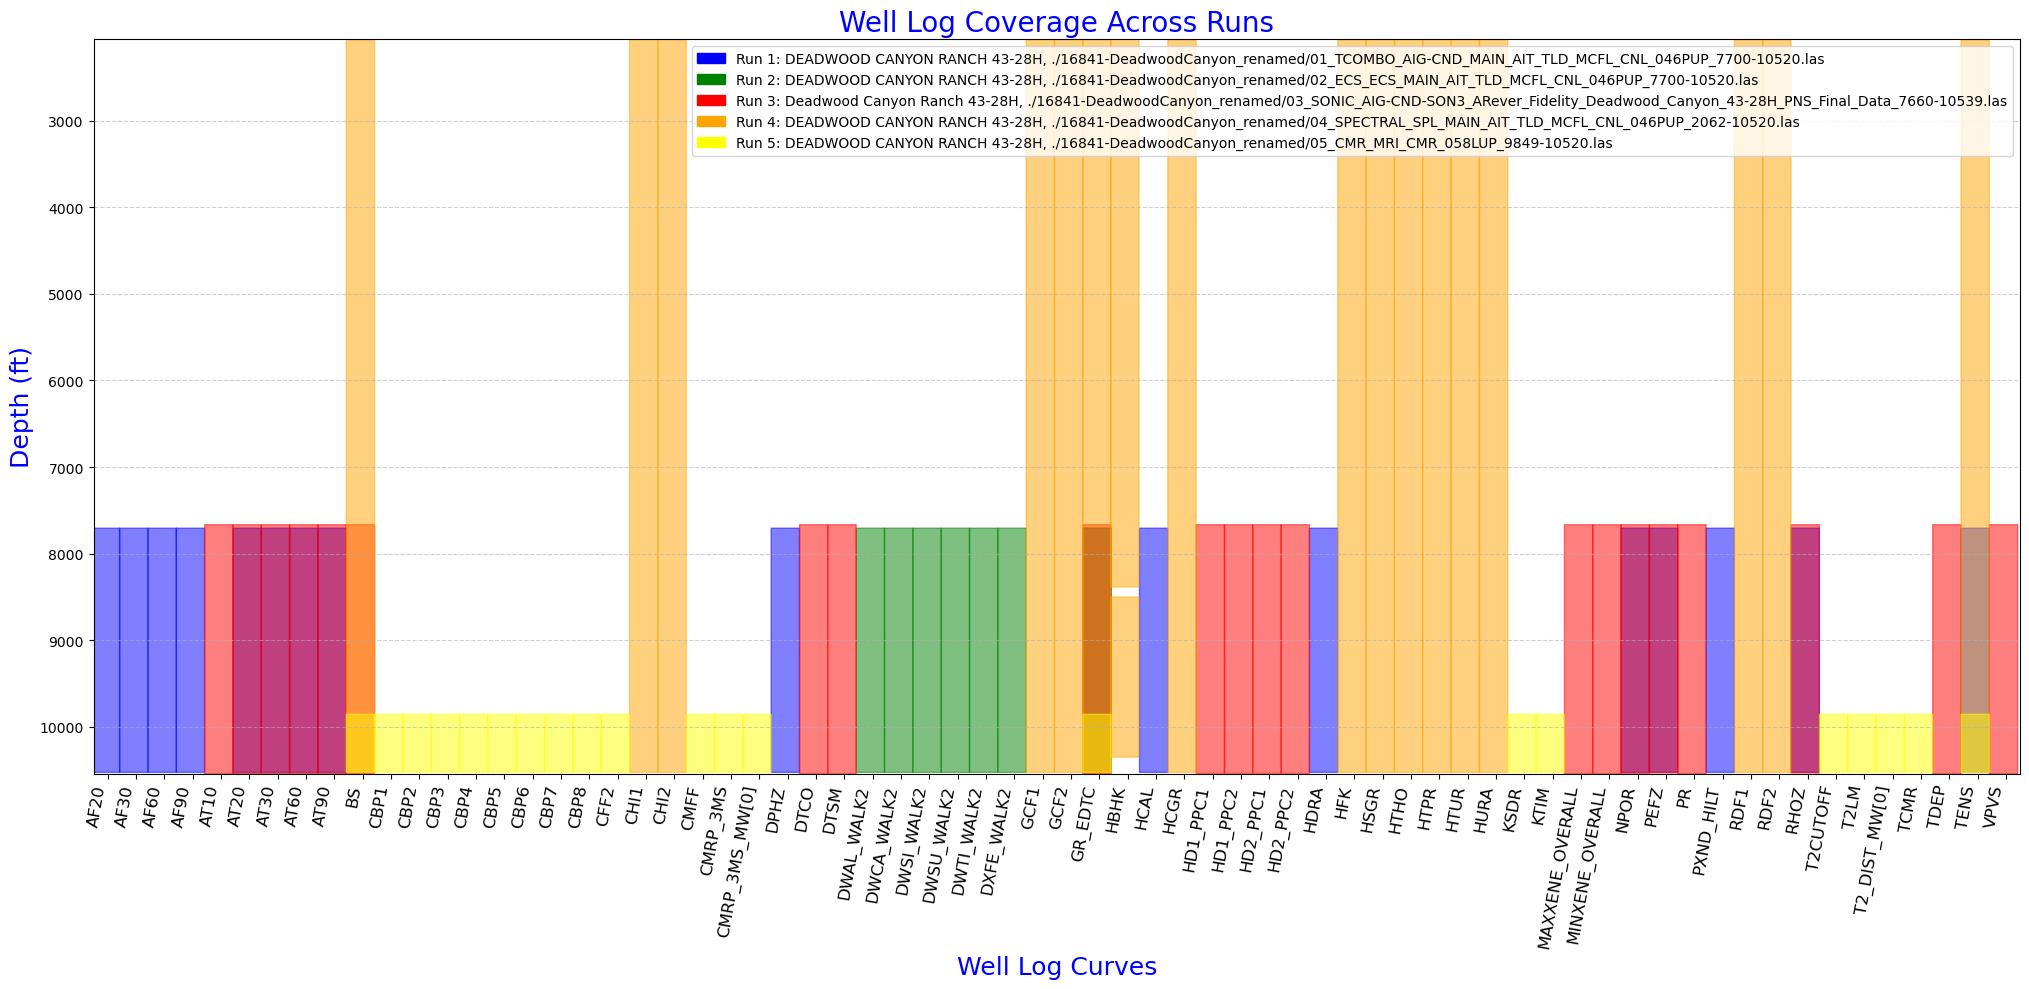

In [3]:
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches  # Import for manually creating colored legend labels



# Function to read LAS file and extract depth and log availability
def get_well_nan(file):
    las = lasio.read(file)
    df_log = las.df()
    df_log.index = las["DEPT"]
    well_nan = df_log.notnull().astype(int)  # Convert to binary (1=Available, 0=Missing)
    wellname = las.well.WELL.value if "WELL" in las.well else file  # Get well name
    return wellname, df_log.index, well_nan

# Read all LAS files and store data
las_data = [get_well_nan(file) for file in las_files]

# Get a unique list of all well log curves across runs
all_available_curves = sorted(set().union(*[df.columns for _, _, df in las_data]))

# Determine global min and max depth across all runs
min_depth = min(min(depth) for _, depth, _ in las_data)
max_depth = max(max(depth) for _, depth, _ in las_data)

# Assign distinct colors for each run
run_colors = ["blue", "green", "red", "orange", "yellow", "black","purple","cyan","gray","violet","limegreen","teal"]
alpha = 0.5  # Transparency for shading

# Create figure with tracks for all unique curves
fig, ax = plt.subplots(figsize=(len(all_available_curves) * 0.3, 10))  # Increase width for better label spacing

# Well name storage for legend (with correct colors)
legend_patches = []

# Loop through each LAS file and shade where logs are present
for run_index, (wellname, depth, well_nan) in enumerate(las_data):
    legend_patches.append(mpatches.Patch(color=run_colors[run_index], label=f"Run {run_index+1}: {wellname}, {las_files[run_index]}"))    
    #legend_patches.append(mpatches.Patch(color=run_colors[run_index], label=f"Run {run_index+1}: {wellname}"))
    for j, curve in enumerate(all_available_curves):
        if curve in well_nan.columns:
            ax.fill_betweenx(depth, j - 0.6, j + 0.4, where=well_nan[curve] == 1, 
                             color=run_colors[run_index], alpha=alpha)

# Format plot
ax.set_xlim(-0.5, len(all_available_curves) - 0.5)  # Keep x-axis aligned
ax.set_ylim(max_depth, min_depth)  # Ensure depth increases downward
ax.set_xticks(range(len(all_available_curves)))
ax.set_xticklabels(all_available_curves, rotation=80, fontsize=12, ha="right")  # Rotate & align right
ax.set_xlabel("Well Log Curves", fontsize=18, color = 'blue')
ax.set_ylabel("Depth (ft)", fontsize=18, color = 'blue')
ax.set_title("Well Log Coverage Across Runs", fontsize=20, color='blue')
ax.grid(axis="y", linestyle="--", alpha=0.6)

# Add well names to legend (ensuring correct colors)
ax.legend(handles=legend_patches, loc="upper right", fontsize=10, frameon=True)

plt.subplots_adjust(bottom=0.25)  # Extra space for x-axis labels
plt.tight_layout()

# **Create output filenames using the well name**
wellname = wellname.replace("#", "").replace(" ", "_")  # Sanitize well name


# **Save the image**
'''image_filename = f"Depth_plot_Andy_{wellname}_{file_directory}_colored_by_las_file.png"'''
image_filename = f"Depth_plot_Andy_{wellname}_{file_directory}_colored_by_las_file.png"
fig.savefig(image_filename, format="png", dpi=300, bbox_inches="tight")
print(f"Plot saved as {image_filename}_colored_by_las_file")

plt.show()



In [4]:
import os
import numpy as np
import pandas as pd
import lasio
import panel as pn

pn.extension("tabulator", sizing_mode="stretch_width")

# ---- Requires las_files from your folder-picker cell ----
if "las_files" not in globals() or not las_files:
    raise ValueError("`las_files` is empty. Run your folder-selection cell first.")

# ---- Simple cache so switching files is fast ----
_LAS_CACHE = {}
def read_las_cached(path):
    if path not in _LAS_CACHE:
        _LAS_CACHE[path] = lasio.read(path)
    return _LAS_CACHE[path]

# ---- UI widgets ----
file_names = [os.path.basename(p) for p in las_files]
file_map = dict(zip(file_names, las_files))

file_selector = pn.widgets.Select(name="LAS file", options=file_names, width=800)

prev_btn = pn.widgets.Button(name="◀ Prev", button_type="default")
next_btn = pn.widgets.Button(name="Next ▶", button_type="default")

sample_curve_choices = pn.widgets.MultiChoice(
    name="Sample curves (shown in table)",
    options=["DEPT","GR","RHOZ","RHOB","TNPH","NPOR","RT","RS","TCMR","CMRP_3MS","BFV","DCAL","CALI","BS","DRHO"],
    value=["DEPT","GR","RHOZ","TNPH"]
)

nrows = pn.widgets.IntInput(name="Sample rows", value=5, start=1, end=50)

# ---- Output panes ----
header_md = pn.pane.Markdown("")
curves_tbl = pn.widgets.Tabulator(pd.DataFrame(), height=260, pagination="local", page_size=12)
well_tbl   = pn.widgets.Tabulator(pd.DataFrame(), height=260, pagination="local", page_size=12)
depth_tbl  = pn.widgets.Tabulator(pd.DataFrame(), height=140)
sample_tbl = pn.widgets.Tabulator(pd.DataFrame(), height=220)

def build_review(file_key, curve_list, nrows_):
    if not file_key:
        return

    path = file_map[file_key]
    las = read_las_cached(path)

    # --- Header / version ---
    las_version = ""
    try:
        if las.version:
            # las.version is a Section; keep it short
            las_version = ", ".join([f"{k}:{v.value}" for k, v in las.version.items() if hasattr(v, "value")])
    except Exception:
        las_version = ""

    header_md.object = (
        f"## Reviewing `{file_key}`\n"
        f"**Path:** `{path}`  \n"
        f"**LAS Version:** `{las_version or 'N/A'}`"
    )

    # --- Well section ---
    well_info = {}
    if getattr(las, "well", None):
        for k, v in las.well.items():
            try:
                unit = (v.unit or "").strip()
                val = v.value
                well_info[str(k)] = f"{val} {unit}".strip() if unit else val
            except Exception:
                well_info[str(k)] = str(v)

    well_df = pd.DataFrame(
        [{"Mnemonic": k, "Value": v} for k, v in well_info.items()]
    )

    # --- Curves section ---
    curve_df = pd.DataFrame(
        [{"Mnemonic": c.mnemonic, "Unit": c.unit, "Description": c.descr} for c in las.curves]
    )

    # --- Depth range ---
    if "DEPT" in las.keys():
        d = np.asarray(las["DEPT"], float)
        d = d[np.isfinite(d)]
        if d.size:
            depth_df = pd.DataFrame([{"Top (min)": float(np.min(d)), "Base (max)": float(np.max(d))}])
        else:
            depth_df = pd.DataFrame([{"Error": "DEPT exists but contains no finite values"}])
    else:
        depth_df = pd.DataFrame([{"Error": "Depth curve ('DEPT') not found"}])

    # --- Sample data table ---
    chosen = [c for c in curve_list if c in las.keys()]
    if "DEPT" in las.keys() and "DEPT" not in chosen:
        chosen = ["DEPT"] + chosen

    if chosen:
        # Build from LAS curves directly
        sample = {}
        for c in chosen:
            try:
                sample[c] = np.asarray(las[c])[: int(nrows_)]
            except Exception:
                sample[c] = [np.nan] * int(nrows_)
        sample_df = pd.DataFrame(sample)
    else:
        sample_df = pd.DataFrame({"Info": ["No selected curves found in this file."]})

    # Push into tables
    curves_tbl.value = curve_df
    well_tbl.value   = well_df
    depth_tbl.value  = depth_df
    sample_tbl.value = sample_df

# Reactive updates (no .map)
def update_all(*_):
    build_review(file_selector.value, sample_curve_choices.value, nrows.value)

file_selector.param.watch(lambda e: update_all(), "value")
sample_curve_choices.param.watch(lambda e: update_all(), "value")
nrows.param.watch(lambda e: update_all(), "value")

# Prev/Next navigation (robust)
def _go(delta):
    opts = list(file_selector.options)  # current options (source of truth)
    cur = file_selector.value

    if not opts:
        return

    # If cur is None or not found, jump to start
    if cur not in opts:
        file_selector.value = opts[0]
        return

    idx = opts.index(cur)
    idx2 = max(0, min(len(opts) - 1, idx + int(delta)))
    file_selector.value = opts[idx2]

prev_btn.on_click(lambda e: _go(-1))
next_btn.on_click(lambda e: _go(+1))

# Initial render
file_selector.value = file_names[0]
update_all()

pn.Column(
    "# Well Log Review (Panel replacement for the print loop)",
    pn.Row(prev_btn, next_btn, file_selector),
    pn.Row(sample_curve_choices, nrows),
    pn.pane.Markdown("---"),
    header_md,
    pn.pane.Markdown("### Curve Inventory"),
    curves_tbl,
    pn.pane.Markdown("### Well Header"),
    well_tbl,
    pn.pane.Markdown("### Depth Range"),
    depth_tbl,
    pn.pane.Markdown("### Sample Data"),
    sample_tbl,
)


Column(sizing_mode='stretch_width')
    [0] Markdown(str, sizing_mode='stretch_width')
    [1] Row(sizing_mode='stretch_width')
        [0] Button(name='◀ Prev', sizing_mode='stretch_width')
        [1] Button(name='Next ▶', sizing_mode='stretch_width')
        [2] Select(name='LAS file', options=['01_TCOMBO_AIG-CND_MAIN_A...], value='01_TCOMBO_AIG-CND_MAIN_AI..., width=800)
    [2] Row(sizing_mode='stretch_width')
        [0] MultiChoice(name='Sample curves (..., options=['DEPT', 'GR', ...], sizing_mode='stretch_width', value=['DEPT', 'GR', ...])
        [1] IntInput(end=50, name='Sample rows', sizing_mode='stretch_width', start=1, value=5)
    [3] Markdown(str, sizing_mode='stretch_width')
    [4] Markdown(str, sizing_mode='stretch_width')
    [5] Markdown(str, sizing_mode='stretch_width')
    [6] Tabulator(height=260, page_size=12, pagination='local', sizing_mode='stretch_width', value=     Mnemonic  ...)
    [7] Markdown(str, sizing_mode='stretch_width')
    [8] Tabulator(height=260, page_size=12, pagination='local', sizing_mode='stretch_width', value=   Mnemonic   ...)
    [9] Markdown(str, sizing_mode='stretch_width')
    [10] Tabulator(height=140, sizing_mode='stretch_width', value=   Top (min)  ...)
    [11] Markdown(str, sizing_mode='stretch_width')
    [12] Tabulator(height=220, sizing_mode='stretch_width', value=     DEPT    R...)